In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
from sklearn.metrics import mean_squared_error, r2_score

#### Preliminary analysis of data and stationarity / ACF / PCF plots for AS14.01

In [2]:
df = pd.read_csv('data/data_arima.csv')

            mood
time            
2014-02-17   NaN
2014-02-18   NaN
2014-02-19   NaN
2014-02-20   NaN
2014-02-21   NaN
...          ...
2014-05-01   8.0
2014-05-02   7.6
2014-05-03   8.0
2014-05-04   8.0
2014-05-05   NaN

[78 rows x 1 columns]


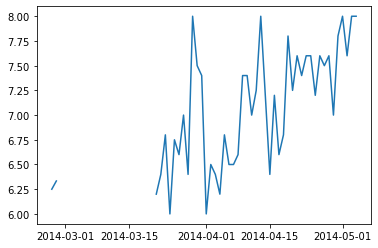

In [3]:
def getPersonMoodArimaSet(person):
    """
        Get the arima mood dataset for a given person.
        
        @param string person:       the id of the person
    """
    # Get mood data for a particular person and set time as index
    mood = df.loc[df["id"] == person][["mood", "time"]]
    mood.set_index(pd.DatetimeIndex(pd.to_datetime(mood.time)), inplace = True)
    mood.drop('time',axis=1,inplace=True)

    # Arima needs a full date range, so fill missing dates
    full_time_range = pd.date_range(mood.index.min(), mood.index.max())
    mood.reindex(full_time_range)
    mood = mood.asfreq('d') # necessary for arima
    
    return mood

mood = getPersonMoodArimaSet("AS14.01")
print(mood)
plt.plot(mood)

#### Stationarity check.

In [4]:
mood_dropna = mood.dropna() ## drop NaN's because adfuller cannot handle nans
result = adfuller(mood_dropna)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -3.5182590351214746
p-value: 0.007530360619884317
Critical Values:
	1%: -3.5812576580093696
	5%: -2.9267849124681518
	10%: -2.6015409829867675


This is unexpected to me, because it should be stationary when p value < 0.05 and critical values reasonably close to ADF statistic (according to https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7). 

The graph does not seem stationary to me (there is a clear upwards trend) but these values seem to indicate that the mood data is in fact stationary.

Analyse what happens if we cut off the missing days (there is a big gap) in the beginning and the 1 missing day at the end:

In [5]:
mood_cutoff = mood.iloc[32:-1] ## drop everything before streak
print(mood_cutoff)

            mood
time            
2014-03-21  6.20
2014-03-22  6.40
2014-03-23  6.80
2014-03-24  6.00
2014-03-25  6.75
2014-03-26  6.60
2014-03-27  7.00
2014-03-28  6.40
2014-03-29  8.00
2014-03-30  7.50
2014-03-31  7.40
2014-04-01  6.00
2014-04-02  6.50
2014-04-03  6.40
2014-04-04  6.20
2014-04-05  6.80
2014-04-06  6.50
2014-04-07  6.50
2014-04-08  6.60
2014-04-09  7.40
2014-04-10  7.40
2014-04-11  7.00
2014-04-12  7.25
2014-04-13  8.00
2014-04-14  7.20
2014-04-15  6.40
2014-04-16  7.20
2014-04-17  6.60
2014-04-18  6.80
2014-04-19  7.80
2014-04-20  7.25
2014-04-21  7.60
2014-04-22  7.40
2014-04-23  7.60
2014-04-24  7.60
2014-04-25  7.20
2014-04-26  7.60
2014-04-27  7.50
2014-04-28  7.60
2014-04-29  7.00
2014-04-30  7.80
2014-05-01  8.00
2014-05-02  7.60
2014-05-03  8.00
2014-05-04  8.00


In [6]:
result = adfuller(mood_cutoff)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -3.6796223894258437
p-value: 0.004409086719118722
Critical Values:
	1%: -3.5885733964124715
	5%: -2.929885661157025
	10%: -2.6031845661157025


#### ACF / PACF analysis

This can only be done when the time series is stationary. According to the adfuller test, the time series is stationary so we will do ACF / PACF to obtain p,d,q.

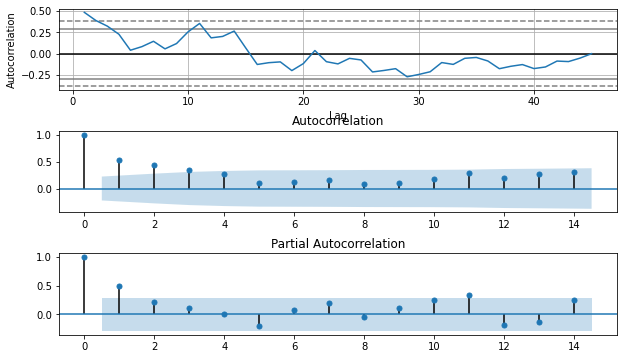

In [7]:
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(10,6))
fig.subplots_adjust(hspace=0.5)

# ACF
autocorrelation_plot(mood_cutoff, ax=ax1) # pandas acf: cannot handle NaN
plot_acf(mood, lags=14, alpha=0.05, use_vlines = True, ax=ax2, missing="drop") # statsmodel acf

# PACF
plot_pacf(mood_cutoff, lags=14, alpha=0.05, use_vlines = True, ax=ax3) # statsmodel acf: cannot handle NaN
plt.show()

Arima try-out

In [8]:
p = 1 # found by acf
d = 0 # no differencing required because already stationary...  (apparantly?)
q = 1 # found by pacf

warnings.filterwarnings("ignore")

Test MSE: 0.24376626533776774
Test r2: -0.02253774882383297


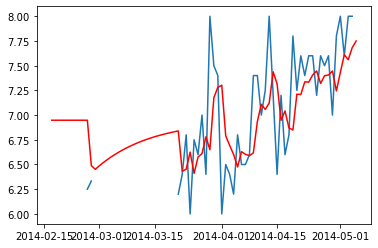

In [9]:
def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return mse, r2

def model_fit_ARIMA(data, order):
    model = ARIMA(data, order=order)
    return model.fit()

# Train model with whole series
model_fit = model_fit_ARIMA(mood, order=(p,d,q))

# Evaluate results
forecast = model_fit.forecast(len(mood))

# Adjust mood (fill NaNs with forecasted values) so we can get MSE for the present mood data
mood_mse = [y if pd.isna(x[0]) else x[0] for x,y in zip(mood.values, forecast)]
mse, r2 = evaluate(mood_mse, forecast)
print(f'Test MSE: {mse}')
print(f'Test r2: {r2}')

# Plot results
plt.plot(mood)
plt.plot(model_fit.fittedvalues, color='red')

Use ARIMA to train and test on unforeseen data. We are gonna check the following sets:
- full range, i.e with the long gap of NaNs at the beginning
- cutoff range, i.e without the long gap and without the first 2 values and without the last value
- dropna, i.e all the non-NaNs

In [10]:
perc_train = 0.8

Test MSE: 0.6544483598207276 	for 1, 0 and 1
Test r2: -7.1241865357055865


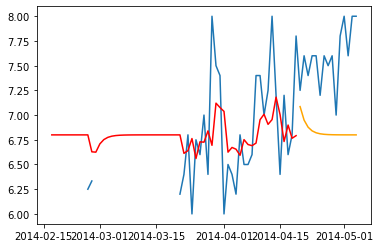

In [11]:
def get_train_set_set(data, perc_train = perc_train):
    """
        Given some data and the desired percentage of the trainign set, return a training set and test set.
        
        @param aray-like data           the data to divide
        @param float perc_train         the training set percentage
    """ 
    # Make training and test set
    train_size = int(len(data) * perc_train) 
    
    return data[0:train_size], data[train_size:].dropna()

def perform_ARIMA(data, pdq_order, perc_train = perc_train):
    """
        Perform arima on some data with a specific order and the desired training set percentage.
 
        @param aray-like data           the data
        @param (int,int,int) pqd_order  the p,d,q order for arima
        @param float perc_train         the training set percentage
        
    """
    
    # Get train and test set
    train, test = get_train_set_set(data, perc_train)

    # Train the model
    model_fit = model_fit_ARIMA(train, order=pdq_order)

    # Forecast and check accuracy
    forecast = model_fit.forecast(len(test))
    mse, r2 = evaluate(test, forecast)
    print(f'Test MSE: {mse} \tfor {pdq_order[0]}, {pdq_order[1]} and {pdq_order[2]}')
    print(f'Test r2: {r2}')

    # Show observed values, fitted values, and forecasted values
    plt.plot(data)
    plt.plot(model_fit.fittedvalues, color='red') 
    plt.plot(test.index, forecast, color='orange')
    plt.show()
    
perform_ARIMA(mood, (p,d,q))

Test MSE: 0.4960313640274113 	for 1, 0 and 1
Test r2: -3.764950663087526


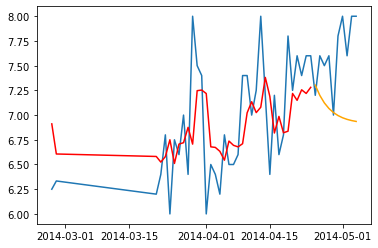

In [12]:
perform_ARIMA(mood_dropna, (p,d,q))

Test MSE: 0.5634167565931091 	for 1, 0 and 1
Test r2: -5.068717723941734


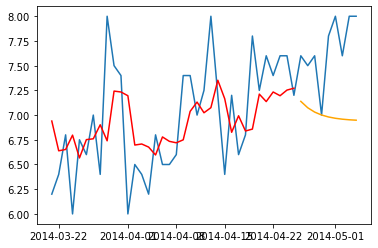

In [13]:
perform_ARIMA(mood_cutoff, (p,d,q))

They are not great. The dropna seems the best though.

Try different p,d,q values because it does not work well with the theoretically obtaines values (1,0,1)

In [14]:
def do_experiment_ARIMA_find_pdq_values(data, p_values, d_values, q_values, doPrint = True):
    """ 
        Try different p,d,q orders on a data-set to find the optimal p,d,q combination.
        
        @param aray-like data           the data to divide
        @param [integers] p_values      the p-values to try
        @param [integers] d_values      the d-values to try
        @param [integers] q_values      the q-values to try
        @param boolean doPrint          whether or not to print the result for each order
    """

    results = []
    
    # Get train and test set
    train, test = get_train_set_set(data, perc_train)

    # Information wrt sizes of train and test
    train_size_na = int(train.count())
    train_size = int(len(train))
    test_size = int(test.count())
    
    # Try out all p, d, q values
    for p in p_values:
        for d in d_values:
            for q in q_values:

                # Train the model
                model_fit = model_fit_ARIMA(train, order=(p, d, q))

                # Forecast and check accuracy
                forecast = model_fit.forecast(len(test))
                mse, r2 = evaluate(test, forecast)
                
                if doPrint:
                    print(f'MSE: {mse} \t\t\tfor {p}, {d} and {q}')
                    print(f'r2: {r2}')
                
                # Save results
                results.append([p,d,q,mse,r2,train_size_na,train_size,test_size])
            
                # Show observed values, fitted values, and forecasted values
                if doPrint:
                    plt.plot(data)
                    plt.plot(model_fit.fittedvalues, color='red')  
                    plt.plot(test.index, forecast, color='orange')
                    plt.show()

    return pd.DataFrame(results, columns=["p", "d", "q", "mse", "r2", "tr_na", "tr", "tst"])
    
p_values = [0,1,2,3,4]
d_values = [0,1,2]
q_values = [0,1,2]

MSE: 0.6659477458520975 			for 0, 0 and 0
r2: -7.266937534715696


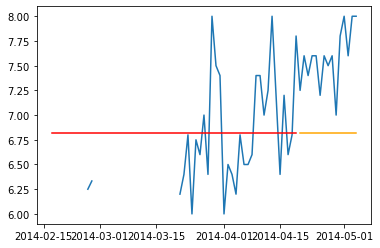

MSE: 0.6599634571589753 			for 0, 0 and 1
r2: -7.192649813007973


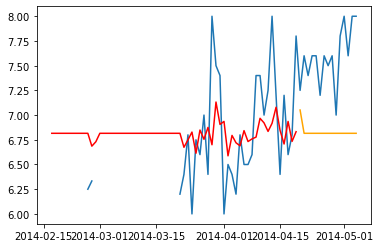

MSE: 0.6551077618888148 			for 0, 0 and 2
r2: -7.132372216550808


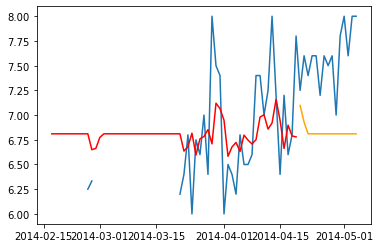

MSE: 0.12749999999999959 			for 0, 1 and 0
r2: -0.5827586206896507


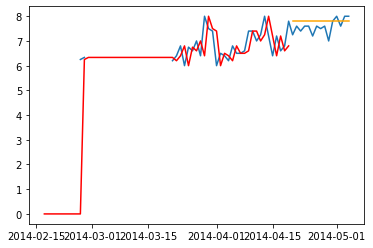

MSE: 0.312936279881885 			for 0, 1 and 1
r2: -2.884726233016505


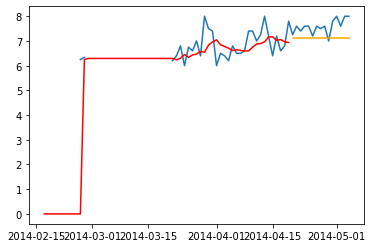

MSE: 0.3510911746321484 			for 0, 1 and 2
r2: -3.35837320233012


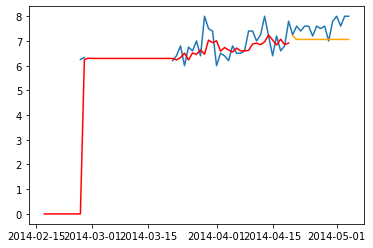

MSE: 84.86750000000038 			for 0, 2 and 0
r2: -1052.5275862069018


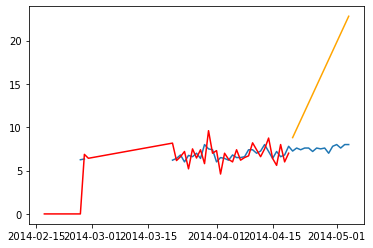

MSE: 0.2658776642272948 			for 0, 2 and 1
r2: -2.3005503145457302


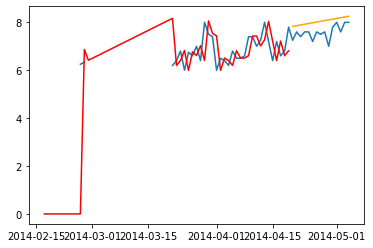

MSE: 0.14793820080570644 			for 0, 2 and 2
r2: -0.8364742168984254


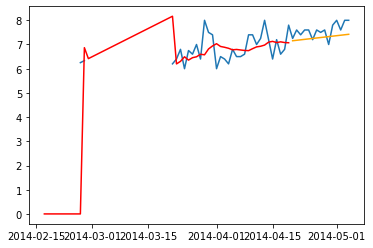

MSE: 0.6555128264376139 			for 1, 0 and 0
r2: -7.137400604053141


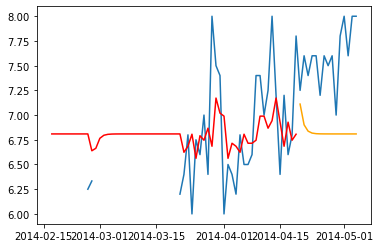

MSE: 0.6544483598207276 			for 1, 0 and 1
r2: -7.1241865357055865


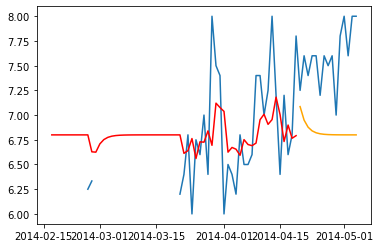

MSE: 0.6578351263264517 			for 1, 0 and 2
r2: -7.166229154397335


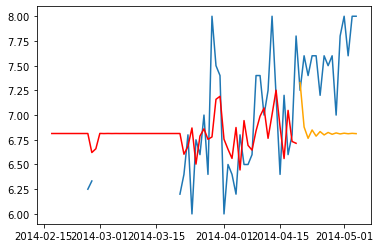

MSE: 0.08220007583533341 			for 1, 1 and 0
r2: -0.020414734507587573


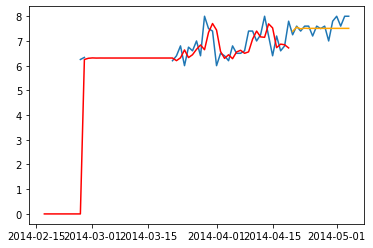

MSE: 0.3655243259015169 			for 1, 1 and 1
r2: -3.5375433560188325


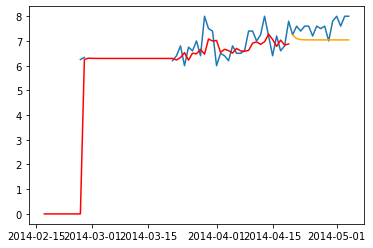

MSE: 0.3770542874323914 			for 1, 1 and 2
r2: -3.680673912953827


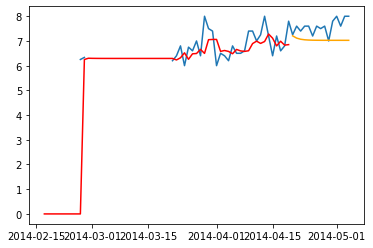

MSE: 39.06455369632145 			for 1, 2 and 0
r2: -483.9392872646802


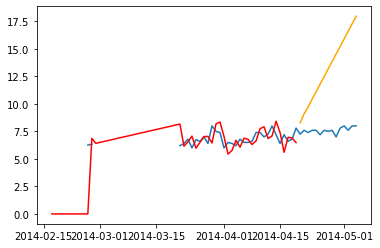

MSE: 0.07246922053739314 			for 1, 2 and 1
r2: 0.10038208988063646


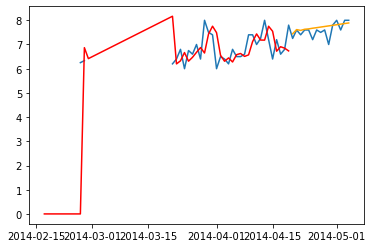

MSE: 0.11806996413353604 			for 1, 2 and 2
r2: -0.4656961064852756


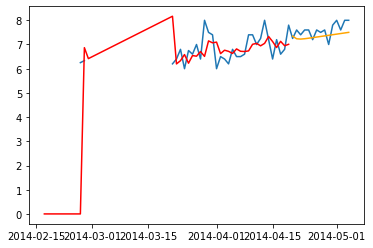

MSE: 0.6536246301817742 			for 2, 0 and 0
r2: -7.1139609263944426


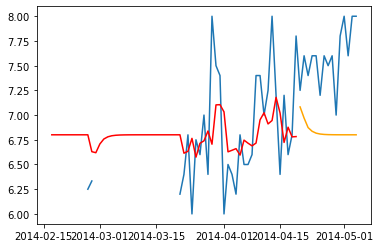

MSE: 0.653784317984875 			for 2, 0 and 1
r2: -7.115943257743279


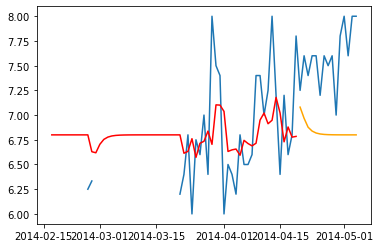

MSE: 0.6540170694778411 			for 2, 0 and 2
r2: -7.118832586621478


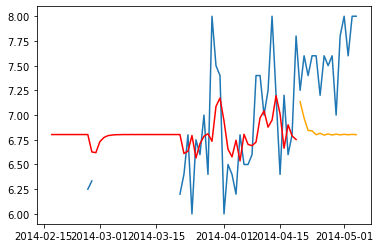

MSE: 0.13799562587892525 			for 2, 1 and 0
r2: -0.7130491488418313


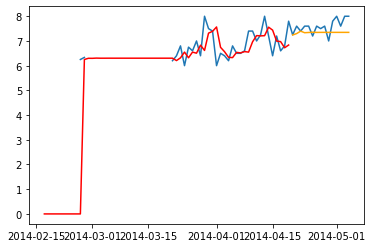

MSE: 0.37499834421065736 			for 2, 1 and 1
r2: -3.655151859166783


MSE: 0.36368512077328397 			for 2, 1 and 2
r2: -3.5147118440821474


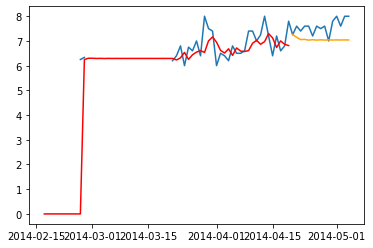

MSE: 11.71501782206438 			for 2, 2 and 0
r2: -144.42780744631654


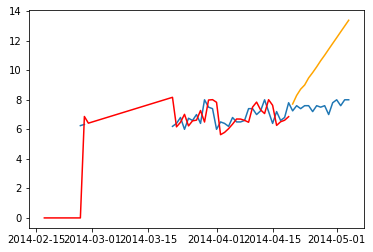

MSE: 0.06101042177970197 			for 2, 2 and 1
r2: 0.24262924687266485


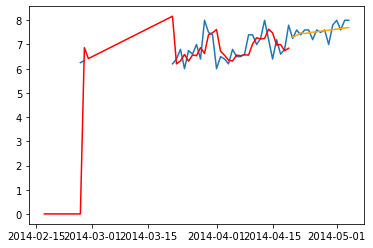

MSE: 0.07295287547595189 			for 2, 2 and 2
r2: 0.09437809753990722


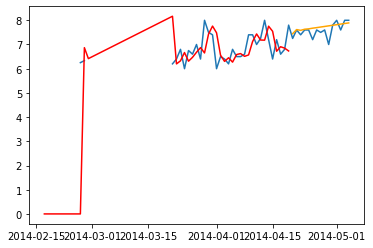

MSE: 0.653857170232651 			for 3, 0 and 0
r2: -7.116847630474291


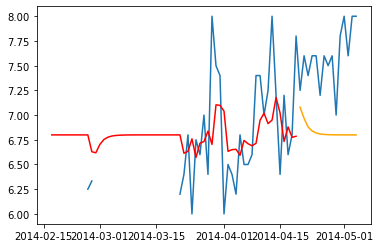

MSE: 0.6538644012361876 			for 3, 0 and 1
r2: -7.116937394656125


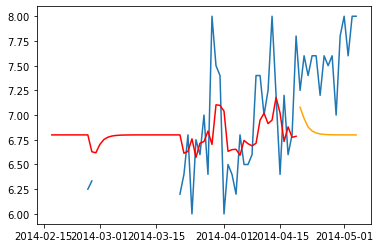

MSE: 0.5256833733425418 			for 3, 0 and 2
r2: -5.525724634597073


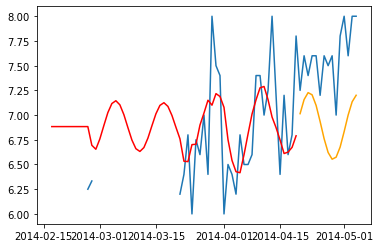

MSE: 0.17050235782456483 			for 3, 1 and 0
r2: -1.116580993684254


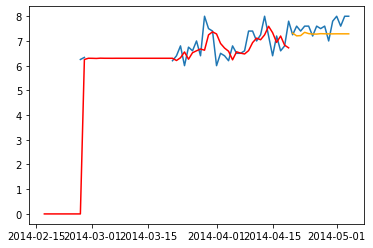

MSE: 0.3752187179011784 			for 3, 1 and 1
r2: -3.6578875325663542


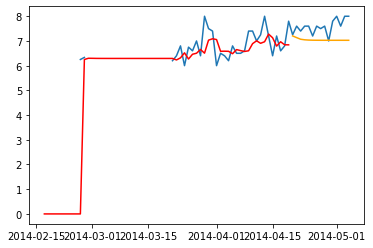

MSE: 0.36092255954245617 			for 3, 1 and 2
r2: -3.4804179805270437


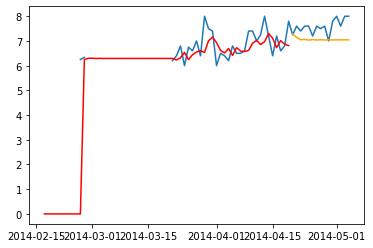

MSE: 7.740036322328504 			for 3, 2 and 0
r2: -95.08320951856078


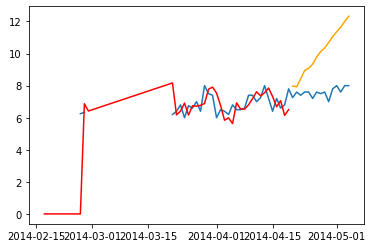

MSE: 0.07131311434195445 			for 3, 2 and 1
r2: 0.11473375299642719


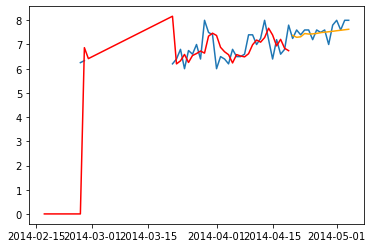

MSE: 0.06811566116945127 			for 3, 2 and 2
r2: 0.15442627513784601


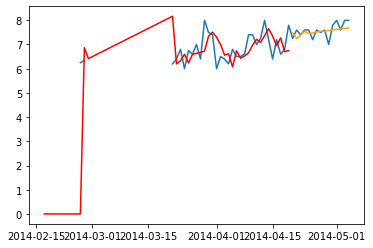

MSE: 0.6538794325656468 			for 4, 0 and 0
r2: -7.117123990470102


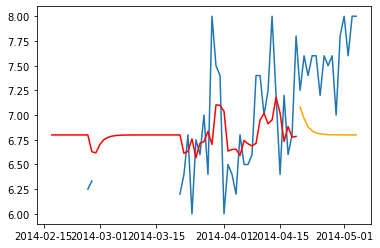

MSE: 0.6552771239234113 			for 4, 0 and 1
r2: -7.134474641807868


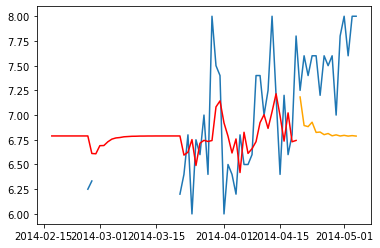

MSE: 0.6676366701662455 			for 4, 0 and 2
r2: -7.287903491718913


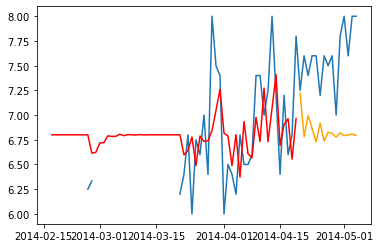

MSE: 0.1406436736507771 			for 4, 1 and 0
r2: -0.7459214660096474


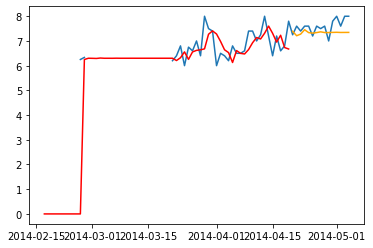

MSE: 0.3763395531972706 			for 4, 1 and 1
r2: -3.671801350035085


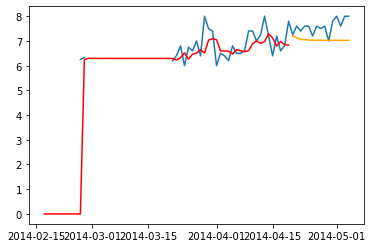

MSE: 0.375717045880579 			for 4, 1 and 2
r2: -3.664073673000293


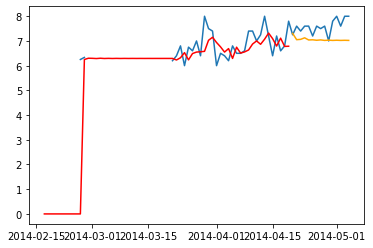

MSE: 7.028396167869175 			for 4, 2 and 0
r2: -86.24905587699669


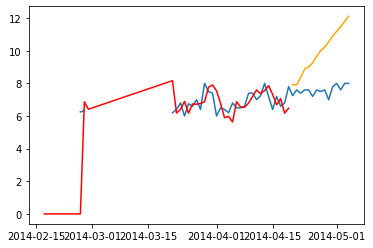

MSE: 0.0616496184340999 			for 4, 2 and 1
r2: 0.2346943918525527


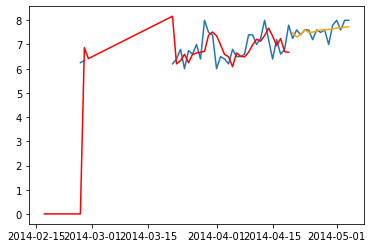

MSE: 0.06688821689485963 			for 4, 2 and 2
r2: 0.1696635144086388


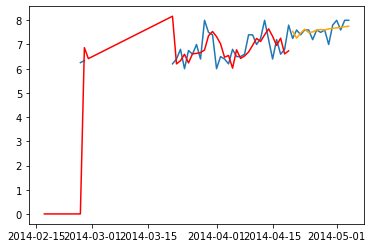

MSE: 0.6204873443189418 			for 0, 0 and 0
r2: -5.683440809818389


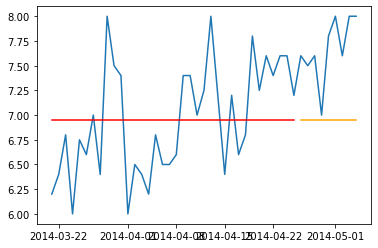

MSE: 0.6213055698056977 			for 0, 0 and 1
r2: -5.692254142853925


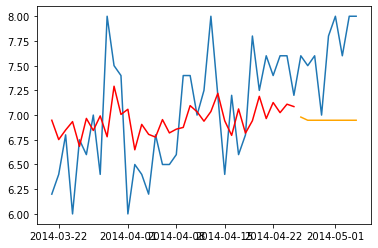

MSE: 0.6201330986926308 			for 0, 0 and 2
r2: -5.67962513219456


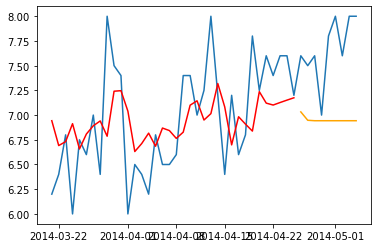

MSE: 0.3211111111111117 			for 0, 1 and 0
r2: -2.4587765957446868


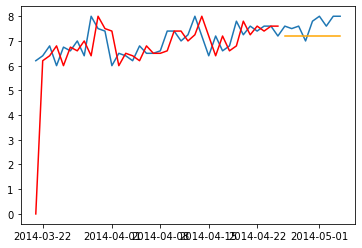

MSE: 0.17206217078833103 			for 0, 1 and 1
r2: -0.8533292332253739


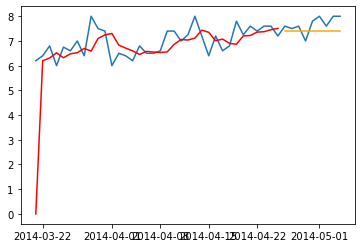

MSE: 0.21110985068361804 			for 0, 1 and 2
r2: -1.2739225937996088


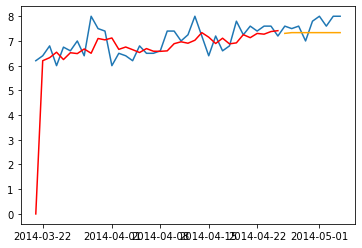

MSE: 7.663333334287568 			for 0, 2 and 0
r2: -81.54388298900173


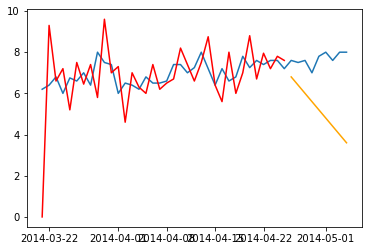

MSE: 0.1844215130714677 			for 0, 2 and 1
r2: -0.9864551274985216


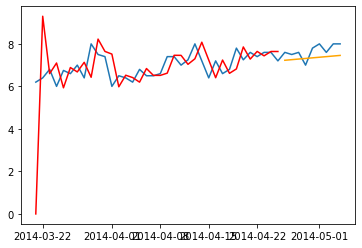

MSE: 0.07720755312735066 			for 0, 2 and 2
r2: 0.16837608998465392


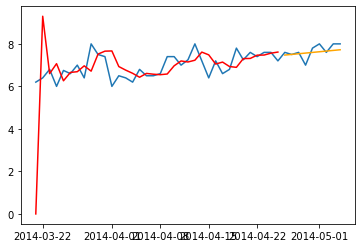

MSE: 0.6117909461451805 			for 1, 0 and 0
r2: -5.589769499702076


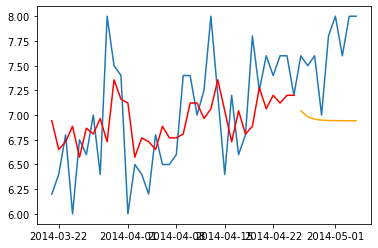

MSE: 0.5634167565931091 			for 1, 0 and 1
r2: -5.068717723941734


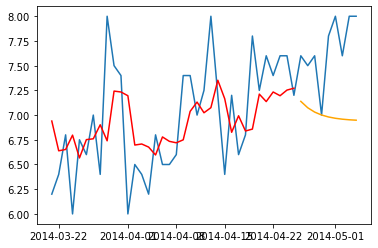

MSE: 0.5746169452576265 			for 1, 0 and 2
r2: -5.189358053971775


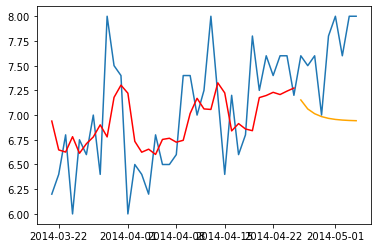

MSE: 0.21862596317427255 			for 1, 1 and 0
r2: -1.3548807203611801


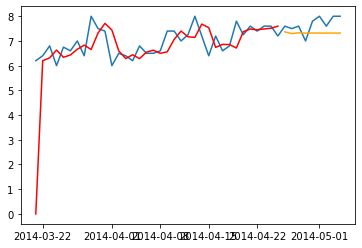

MSE: 0.2440748765206373 			for 1, 1 and 1
r2: -1.6289980050760136


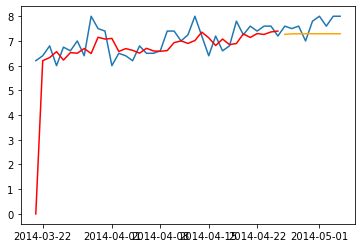

MSE: 0.2697134090943741 			for 1, 1 and 2
r2: -1.9051577309367422


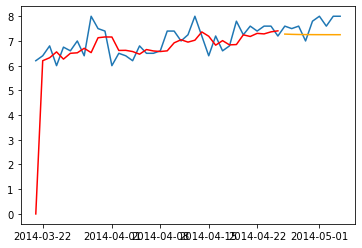

MSE: 3.361461643364608 			for 1, 2 and 0
r2: -35.20723312666665


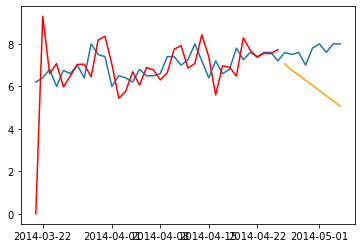

MSE: 0.10780391578943009 			for 1, 2 and 1
r2: -0.16118579507231878


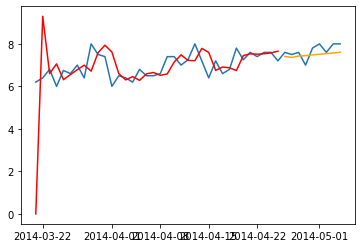

MSE: 0.09463468312737314 			for 1, 2 and 2
r2: -0.019336347515588326


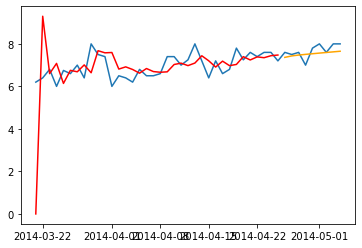

MSE: 0.5782845671412868 			for 2, 0 and 0
r2: -5.228863023729286


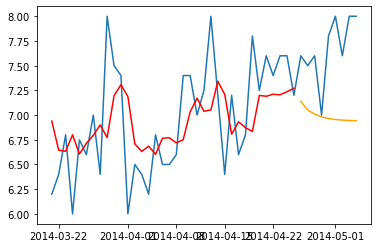

MSE: 0.5708733258617751 			for 2, 0 and 1
r2: -5.149034493989864


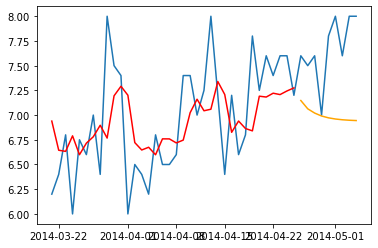

MSE: 0.5770823496076412 			for 2, 0 and 2
r2: -5.215913606146135


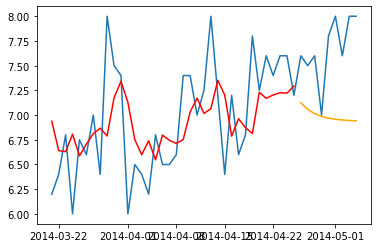

MSE: 0.1896433147414237 			for 2, 1 and 0
r2: -1.0427005976137393


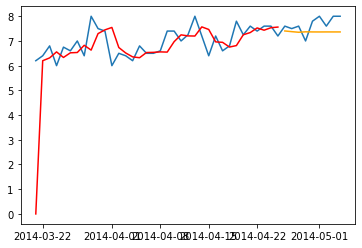

MSE: 0.27374637094308296 			for 2, 1 and 1
r2: -1.948597878509271


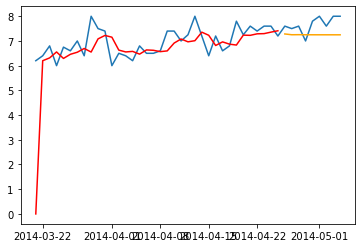

MSE: 0.2657768036408072 			for 2, 1 and 2
r2: -1.862755464748056


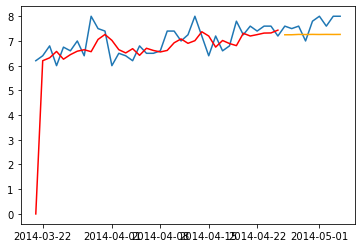

MSE: 1.389834008436781 			for 2, 2 and 0
r2: -13.970286527045113


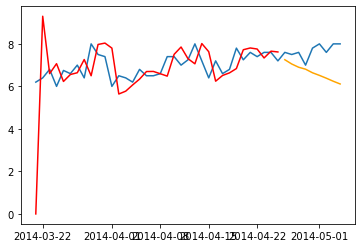

MSE: 0.09264724785107589 			for 2, 2 and 1
r2: 0.0020708675615496164


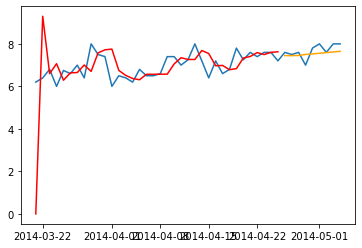

MSE: 0.11298633794076898 			for 2, 2 and 2
r2: -0.217007097500304


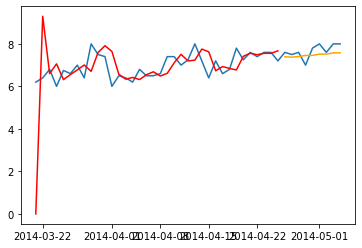

MSE: 0.5697278720357407 			for 3, 0 and 0
r2: -5.136696494001995


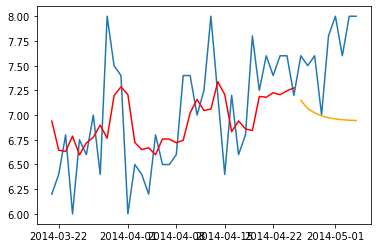

MSE: 0.5694946377313828 			for 3, 0 and 1
r2: -5.134184262798138


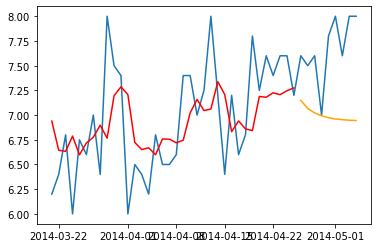

MSE: 0.5522420003583073 			for 3, 0 and 2
r2: -4.948351333646661


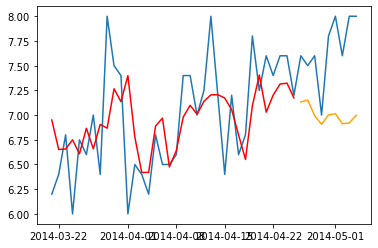

MSE: 0.1778163862840757 			for 3, 1 and 0
r2: -0.91530947992156


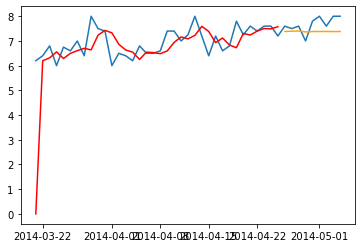

MSE: 0.274064352380814 			for 3, 1 and 1
r2: -1.9520229445273847


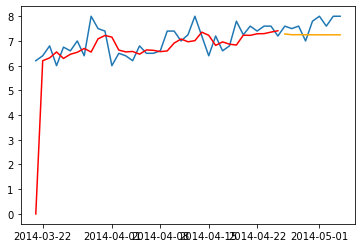

MSE: 0.27193342051615316 			for 3, 1 and 2
r2: -1.9290700880064366


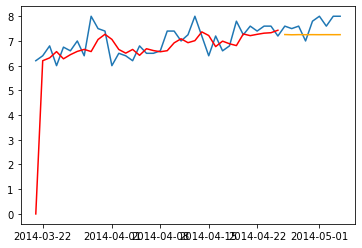

MSE: 0.8872440473643246 			for 3, 2 and 0
r2: -8.556751042089134


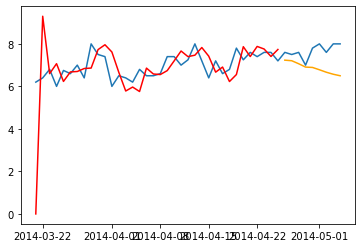

MSE: 0.0816173788179037 			for 3, 2 and 1
r2: 0.12087663773268642


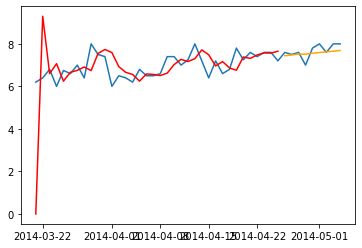

MSE: 0.08611575276691151 			for 3, 2 and 2
r2: 0.07242340769683087


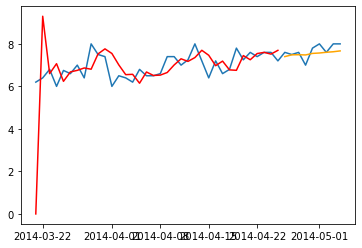

MSE: 0.5653558356125813 			for 4, 0 and 0
r2: -5.0896040804014735


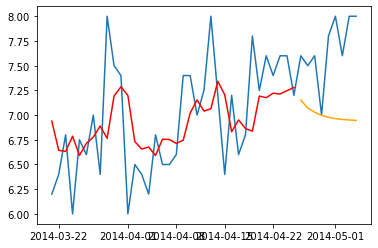

MSE: 0.5531519795564557 			for 4, 0 and 1
r2: -4.958152971286291


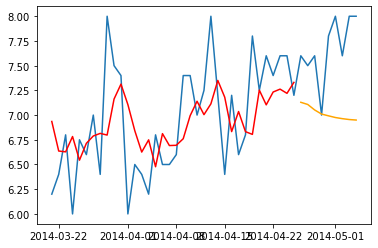

MSE: 0.4327955582347556 			for 4, 0 and 2
r2: -3.661760667156277


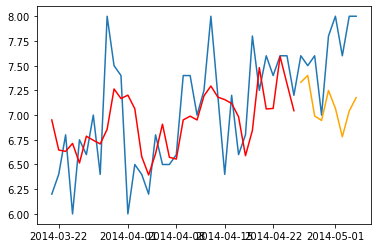

MSE: 0.1834646362674254 			for 4, 1 and 0
r2: -0.97614834277413


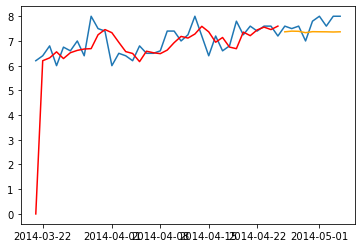

MSE: 0.18843350394749717 			for 4, 1 and 1
r2: -1.0296693909238388


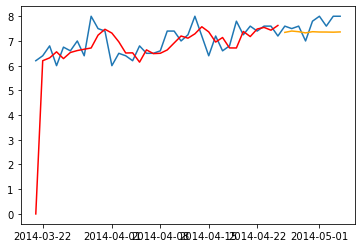

MSE: 0.2793497868694084 			for 4, 1 and 2
r2: -2.0089538213327236


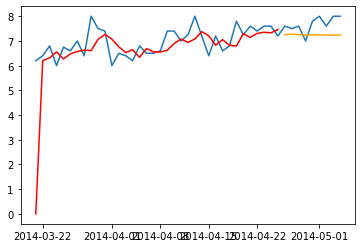

MSE: 0.6659020346248681 			for 4, 2 and 0
r2: -6.172615000613606


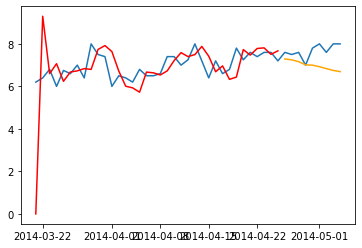

MSE: 0.08622269704432127 			for 4, 2 and 1
r2: 0.07127148130451832


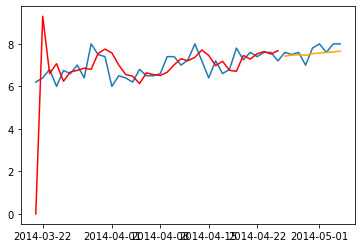

MSE: 0.08845154405300977 			for 4, 2 and 2
r2: 0.047263953684336224


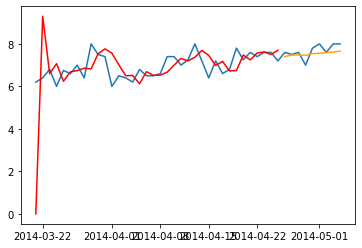

MSE: 0.6239352955458067 			for 0, 0 and 0
r2: -4.993614750680182


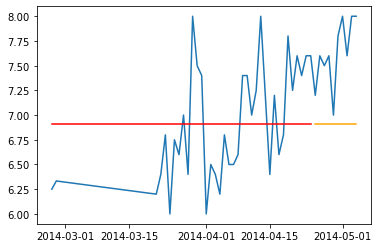

MSE: 0.6176516118648271 			for 0, 0 and 1
r2: -4.933252755665968


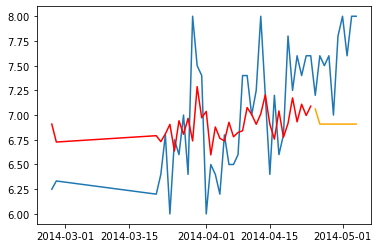

MSE: 0.6014008626130402 			for 0, 0 and 2
r2: -4.777145654303942


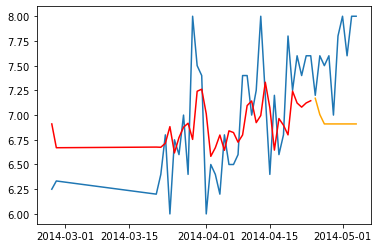

MSE: 0.10500000000000001 			for 0, 1 and 0
r2: -0.008645533141210748


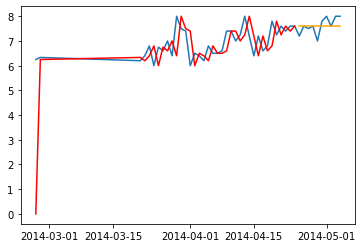

MSE: 0.11560735210094841 			for 0, 1 and 1
r2: -0.11054132661814076


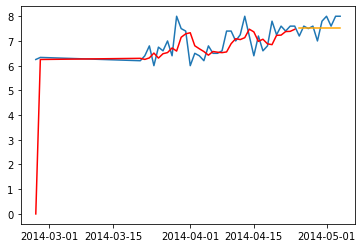

MSE: 0.13966148330242883 			for 0, 1 and 2
r2: -0.34160886937972035


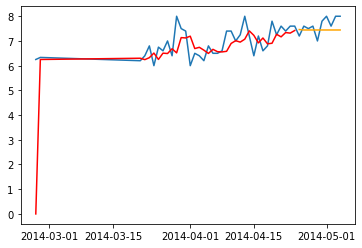

MSE: 0.10499999997933744 			for 0, 2 and 0
r2: -0.008645532942723078


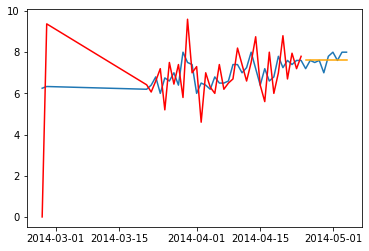

MSE: 0.09989118560952744 			for 0, 2 and 1
r2: 0.04043049366448159


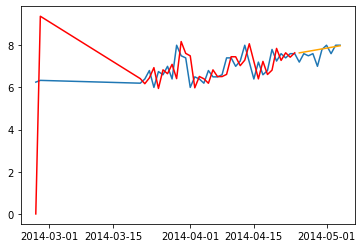

MSE: 0.09201519884831344 			for 0, 2 and 2
r2: 0.1160883876242702


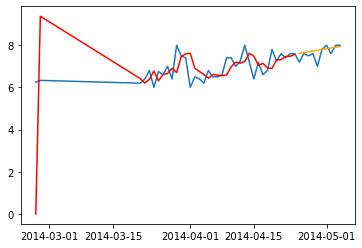

MSE: 0.5867603478265423 			for 1, 0 and 0
r2: -4.636506703425


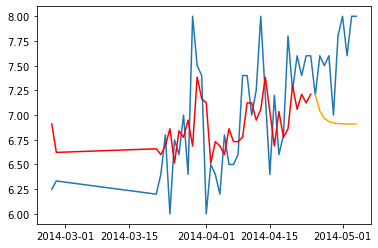

MSE: 0.4960313640274113 			for 1, 0 and 1
r2: -3.764950663087526


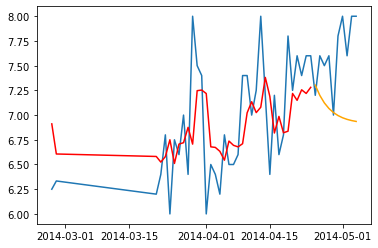

MSE: 0.5169845354813034 			for 1, 0 and 2
r2: -3.9662299277742905


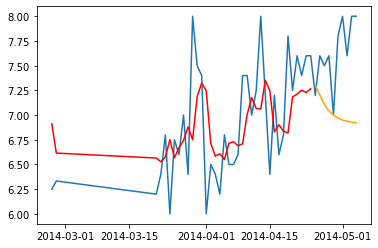

MSE: 0.10500000000000001 			for 1, 1 and 0
r2: -0.008645533141210748


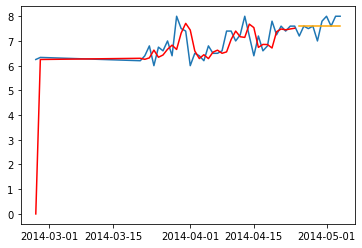

MSE: 0.16876808813494265 			for 1, 1 and 1
r2: -0.6212112212770673


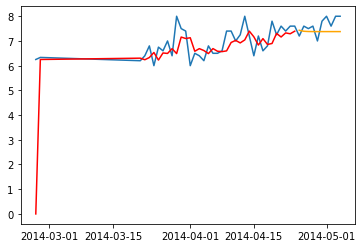

MSE: 0.18784480127204714 			for 1, 1 and 2
r2: -0.804464949779512


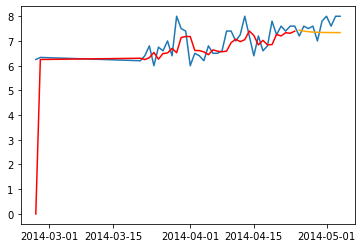

MSE: 0.24698204476960495 			for 1, 2 and 0
r2: -1.3725460592661385


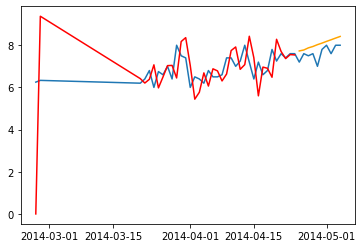

MSE: 0.10421301572846826 			for 1, 2 and 1
r2: -0.0010856458066117458


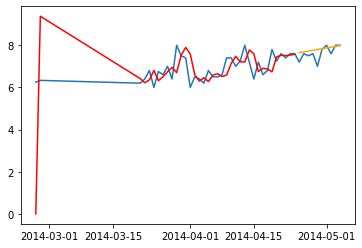

MSE: 0.0799948970424992 			for 1, 2 and 2
r2: 0.23155718499040145


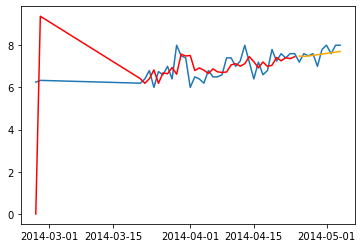

MSE: 0.5240816693631705 			for 2, 0 and 0
r2: -4.034406045755722


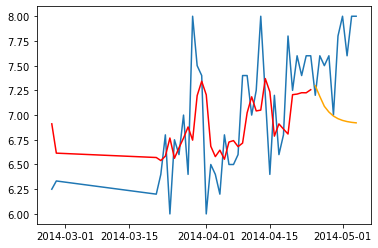

MSE: 0.5097453370147351 			for 2, 0 and 1
r2: -3.8966891163759394


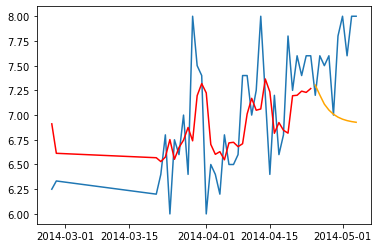

MSE: 0.5078367928032799 			for 2, 0 and 2
r2: -3.8783553583408263


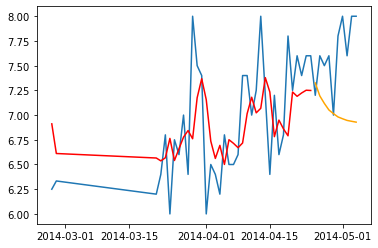

MSE: 0.10571530689940697 			for 2, 1 and 0
r2: -0.01551687703561


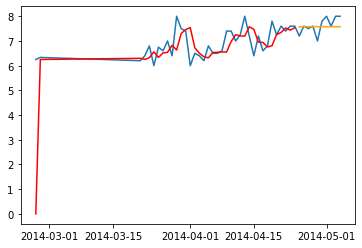

MSE: 0.1913554702221368 			for 2, 1 and 1
r2: -0.8381889550637547


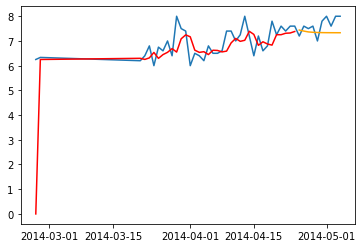

MSE: 0.18371150481386084 			for 2, 1 and 2
r2: -0.7647598925442931


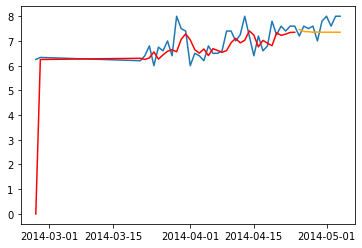

MSE: 0.10827371729688817 			for 2, 2 and 0
r2: -0.0400933457914332


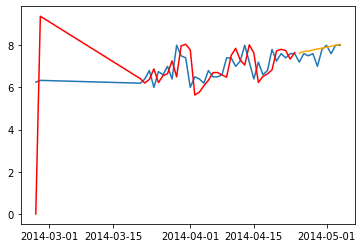

MSE: 0.09861301093321097 			for 2, 2 and 1
r2: 0.052708828691537035


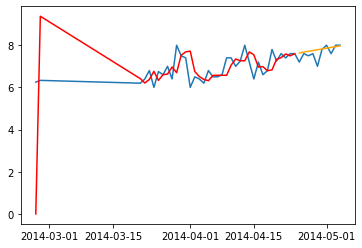

MSE: 0.10917739090319803 			for 2, 2 and 2
r2: -0.048774168138309815


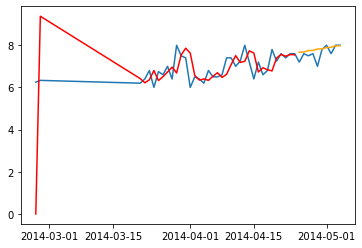

MSE: 0.5111790215591169 			for 3, 0 and 0
r2: -3.9104613022009325


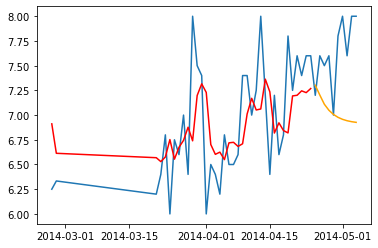

MSE: 0.5091226346181609 			for 3, 0 and 1
r2: -3.8907073450351684


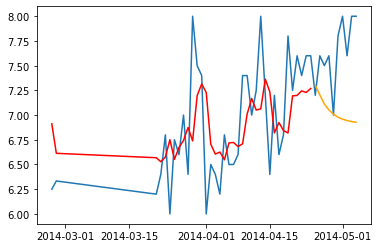

MSE: 0.5084106473949717 			for 3, 0 and 2
r2: -3.8838678904416124


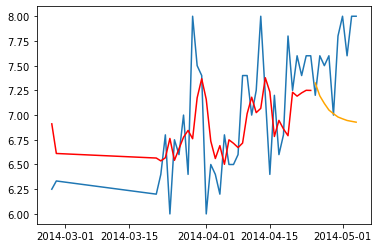

MSE: 0.10805757404479284 			for 3, 1 and 0
r2: -0.038017041736722934


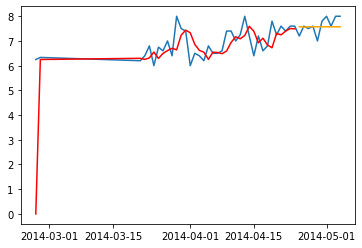

MSE: 0.1914061245279568 			for 3, 1 and 1
r2: -0.83867554781899


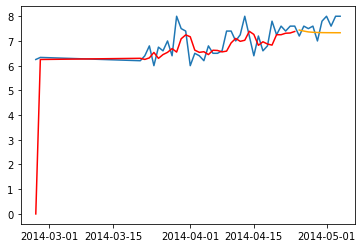

MSE: 0.18843966351392066 			for 3, 1 and 2
r2: -0.8101792844757032


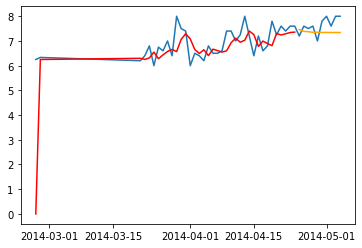

MSE: 0.17805466682312274 			for 3, 2 and 0
r2: -0.7104194699627551


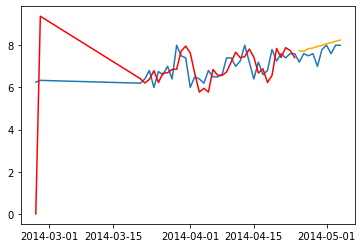

MSE: 0.1021862527646579 			for 3, 2 and 1
r2: 0.018383739052277415


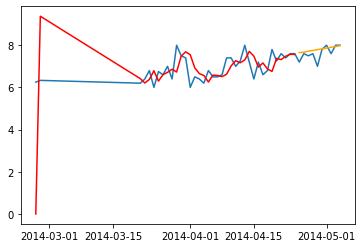

MSE: 0.11247457956924409 			for 3, 2 and 2
r2: -0.08044745023289268


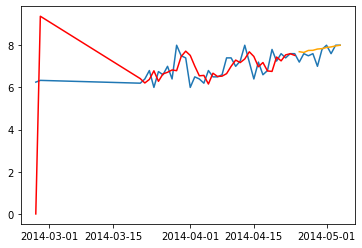

MSE: 0.4909724110869935 			for 4, 0 and 0
r2: -3.716353612747297


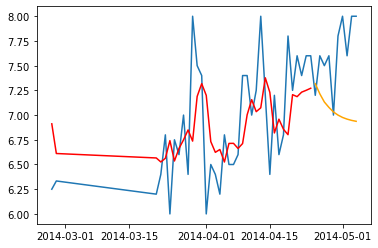

MSE: 0.47485513191706447 			for 4, 0 and 1
r2: -3.561528644736452


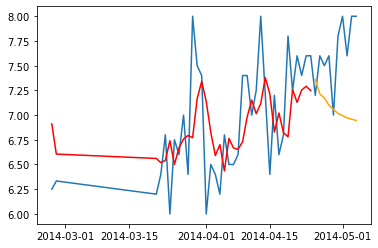

MSE: 0.45391877300234984 			for 4, 0 and 2
r2: -3.3604108837881848


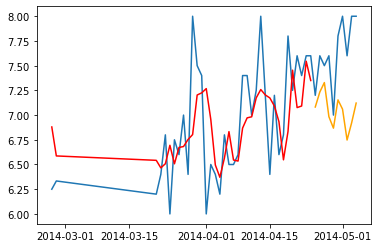

MSE: 0.10743697017222978 			for 4, 1 and 0
r2: -0.03205542912804815


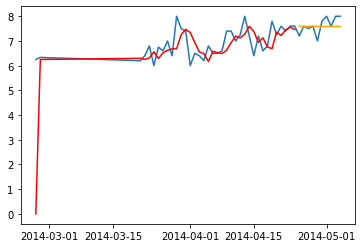

MSE: 0.10921297097840592 			for 4, 1 and 1
r2: -0.049115955604283945


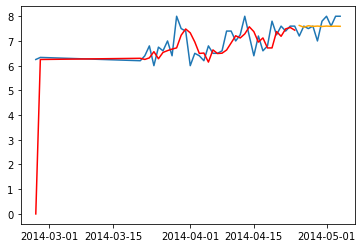

MSE: 0.1862112589302961 			for 4, 1 and 2
r2: -0.7887729003870909


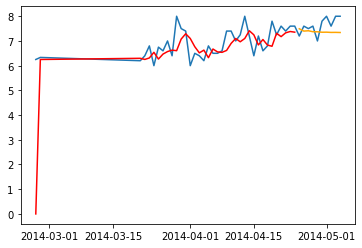

MSE: 0.12589316800490838 			for 4, 2 and 0
r2: -0.20934839582044584


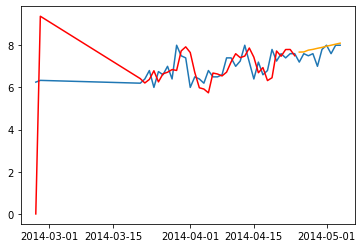

MSE: 0.1081668513876266 			for 4, 2 and 1
r2: -0.03906677605789266


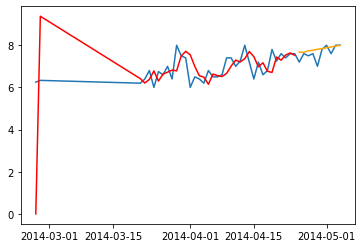

MSE: 0.11570794239912549 			for 4, 2 and 2
r2: -0.11150761190322322


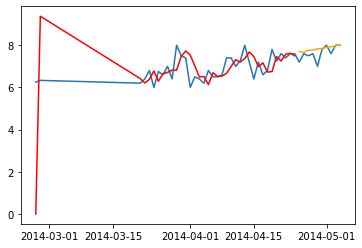

In [15]:
# pdq analysis on full mood range
pdq_results = do_experiment_ARIMA_find_pdq_values(mood, p_values, d_values, q_values)
pdq_results.sort_values('mse', inplace = True)
pdq_results = pdq_results.reset_index()

# pdq analysis on cutoff mood range
pdq_results_cutoff = do_experiment_ARIMA_find_pdq_values(mood_cutoff, p_values, d_values, q_values)
pdq_results_cutoff.sort_values('mse', inplace = True)
pdq_results_cutoff = pdq_results_cutoff.reset_index()

# pdq analysis on dropna mood range
pdq_results_dropna = do_experiment_ARIMA_find_pdq_values(mood_dropna, p_values, d_values, q_values)
pdq_results_dropna.sort_values('mse', inplace = True)
pdq_results_dropna = pdq_results_dropna.reset_index()

In [16]:
dfs_pdq = [pdq_results, pdq_results_cutoff, pdq_results_dropna]

# Combine dataframes
df_pdq = pd.concat(dfs_pdq, axis=1, keys=range(1, len(dfs_pdq) + 1))
df_pdq.columns = df_pdq.columns.map('{0[1]}{0[0]}'.format)
              
# Drop unused index columns
df_pdq = df_pdq.loc[:,~df_pdq.columns.str.startswith('index')]

# Show results                                   
print('1=full range, 2=cutoff, 3=dropna')
df_pdq

1=full range, 2=cutoff, 3=dropna


p1  d1  q1       mse1          r21  tr_na1  tr1  tst1  p2  d2  ...  tr2  \
0    2   2   1   0.061010     0.242629      32   62    15   0   2  ...   36   
1    4   2   1   0.061650     0.234694      32   62    15   3   2  ...   36   
2    4   2   2   0.066888     0.169664      32   62    15   3   2  ...   36   
3    3   2   2   0.068116     0.154426      32   62    15   4   2  ...   36   
4    3   2   1   0.071313     0.114734      32   62    15   4   2  ...   36   
5    1   2   1   0.072469     0.100382      32   62    15   2   2  ...   36   
6    2   2   2   0.072953     0.094378      32   62    15   1   2  ...   36   
7    1   1   0   0.082200    -0.020415      32   62    15   1   2  ...   36   
8    1   2   2   0.118070    -0.465696      32   62    15   2   2  ...   36   
9    0   1   0   0.127500    -0.582759      32   62    15   0   1  ...   36   
10   2   1   0   0.137996    -0.713049      32   62    15   3   1  ...   36   
11   4   1   0   0.140644    -0.745921      32   62    15   4   1  ...   36   
12   0   2   2   0.147938    -0.836474      32   62    15   0   2  ...   36   
13   3   1   0   0.170502    -1.116581      32   62    15   4   1  ...   36   
14   0   2   1   0.265878    -2.300550      32   62    15   2   1  ...   36   
15   0   1   1   0.312936    -2.884726      32   62    15   0   1  ...   36   
16   0   1   2   0.351091    -3.358373      32   62    15   1   1  ...   36   
17   3   1   2   0.360923    -3.480418      32   62    15   1   1  ...   36   
18   2   1   2   0.363685    -3.514712      32   62    15   2   1  ...   36   
19   1   1   1   0.365524    -3.537543      32   62    15   1   1  ...   36   
20   2   1   1   0.374998    -3.655152      32   62    15   3   1  ...   36   
21   3   1   1   0.375219    -3.657888      32   62    15   2   1  ...   36   
22   4   1   2   0.375717    -3.664074      32   62    15   3   1  ...   36   
23   4   1   1   0.376340    -3.671801      32   62    15   4   1  ...   36   
24   1   1   2   0.377054    -3.680674      32   62    15   0   1  ...   36   
25   3   0   2   0.525683    -5.525725      32   62    15   4   0  ...   36   
26   2   0   0   0.653625    -7.113961      32   62    15   3   0  ...   36   
27   2   0   1   0.653784    -7.115943      32   62    15   4   0  ...   36   
28   3   0   0   0.653857    -7.116848      32   62    15   1   0  ...   36   
29   3   0   1   0.653864    -7.116937      32   62    15   4   0  ...   36   
30   4   0   0   0.653879    -7.117124      32   62    15   3   0  ...   36   
31   2   0   2   0.654017    -7.118833      32   62    15   3   0  ...   36   
32   1   0   1   0.654448    -7.124187      32   62    15   2   0  ...   36   
33   0   0   2   0.655108    -7.132372      32   62    15   1   0  ...   36   
34   4   0   1   0.655277    -7.134475      32   62    15   2   0  ...   36   
35   1   0   0   0.655513    -7.137401      32   62    15   2   0  ...   36   
36   1   0   2   0.657835    -7.166229      32   62    15   1   0  ...   36   
37   0   0   1   0.659963    -7.192650      32   62    15   0   0  ...   36   
38   0   0   0   0.665948    -7.266938      32   62    15   0   0  ...   36   
39   4   0   2   0.667637    -7.287903      32   62    15   0   0  ...   36   
40   4   2   0   7.028396   -86.249056      32   62    15   4   2  ...   36   
41   3   2   0   7.740036   -95.083210      32   62    15   3   2  ...   36   
42   2   2   0  11.715018  -144.427807      32   62    15   2   2  ...   36   
43   1   2   0  39.064554  -483.939287      32   62    15   1   2  ...   36   
44   0   2   0  84.867500 -1052.527586      32   62    15   0   2  ...   36   

    tst2  p3  d3  q3      mse3       r23  tr_na3  tr3  tst3  
0      9   1   2   2  0.079995  0.231557      37   37    10  
1      9   0   2   2  0.092015  0.116088      37   37    10  
2      9   2   2   1  0.098613  0.052709      37   37    10  
3      9   0   2   1  0.099891  0.040430      37   37    10  
4      9   3   2   1  0.102186  0.018384      37   37    10

Unexpected results to me, I would not have expected that the full range (with a very long gap between the first days and the rest of the days) would perform better than the cutoff-range or the ranges with NaN dropped.

So it seems like it's not necessary to cut off the period or remove NaNs? We still do a further analysis of this though because it seems unexpected.

Test MSE: 0.06101042177970197 	for 2, 2 and 1
Test r2: 0.24262924687266485


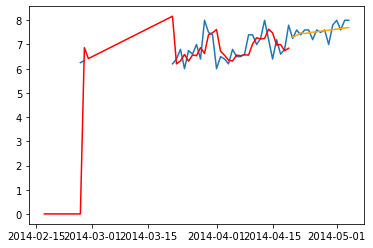

Test MSE: 0.07720755312735066 	for 0, 2 and 2
Test r2: 0.16837608998465392


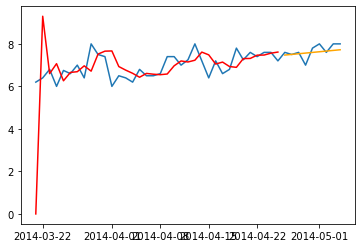

Test MSE: 0.0799948970424992 	for 1, 2 and 2
Test r2: 0.23155718499040145


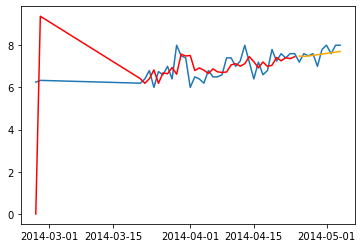

In [17]:
perform_ARIMA(mood, (2,2,1))
perform_ARIMA(mood_cutoff, (0,2,2))
perform_ARIMA(mood_dropna, (1,2,2))

In [18]:
print(f'Full range has {df_pdq["tr_na1"][0]} non-NaN training values (out of {df_pdq["tr1"][0]}) and {df_pdq["tst1"][0]} test values')
print(f'Cutoff range has {df_pdq["tr_na2"][0]} non-NaN training values (out of {df_pdq["tr2"][0]}) and {df_pdq["tst2"][0]} test values')
print(f'Dropnan range has {df_pdq["tr_na3"][0]} non-NaN training values (out of {df_pdq["tr3"][0]}) and {df_pdq["tst3"][0]} test values')

Full range has 32 non-NaN training values (out of 62) and 15 test values
Cutoff range has 36 non-NaN training values (out of 36) and 9 test values
Dropnan range has 37 non-NaN training values (out of 37) and 10 test values


The full range has less non-NaN values to train on and more values to test on than the cutoff/dropna range. Makes it even weirder for me that it performs better.

But on the other hand: this might not even be a big problem. Let's see how many persons have missing mood data. 

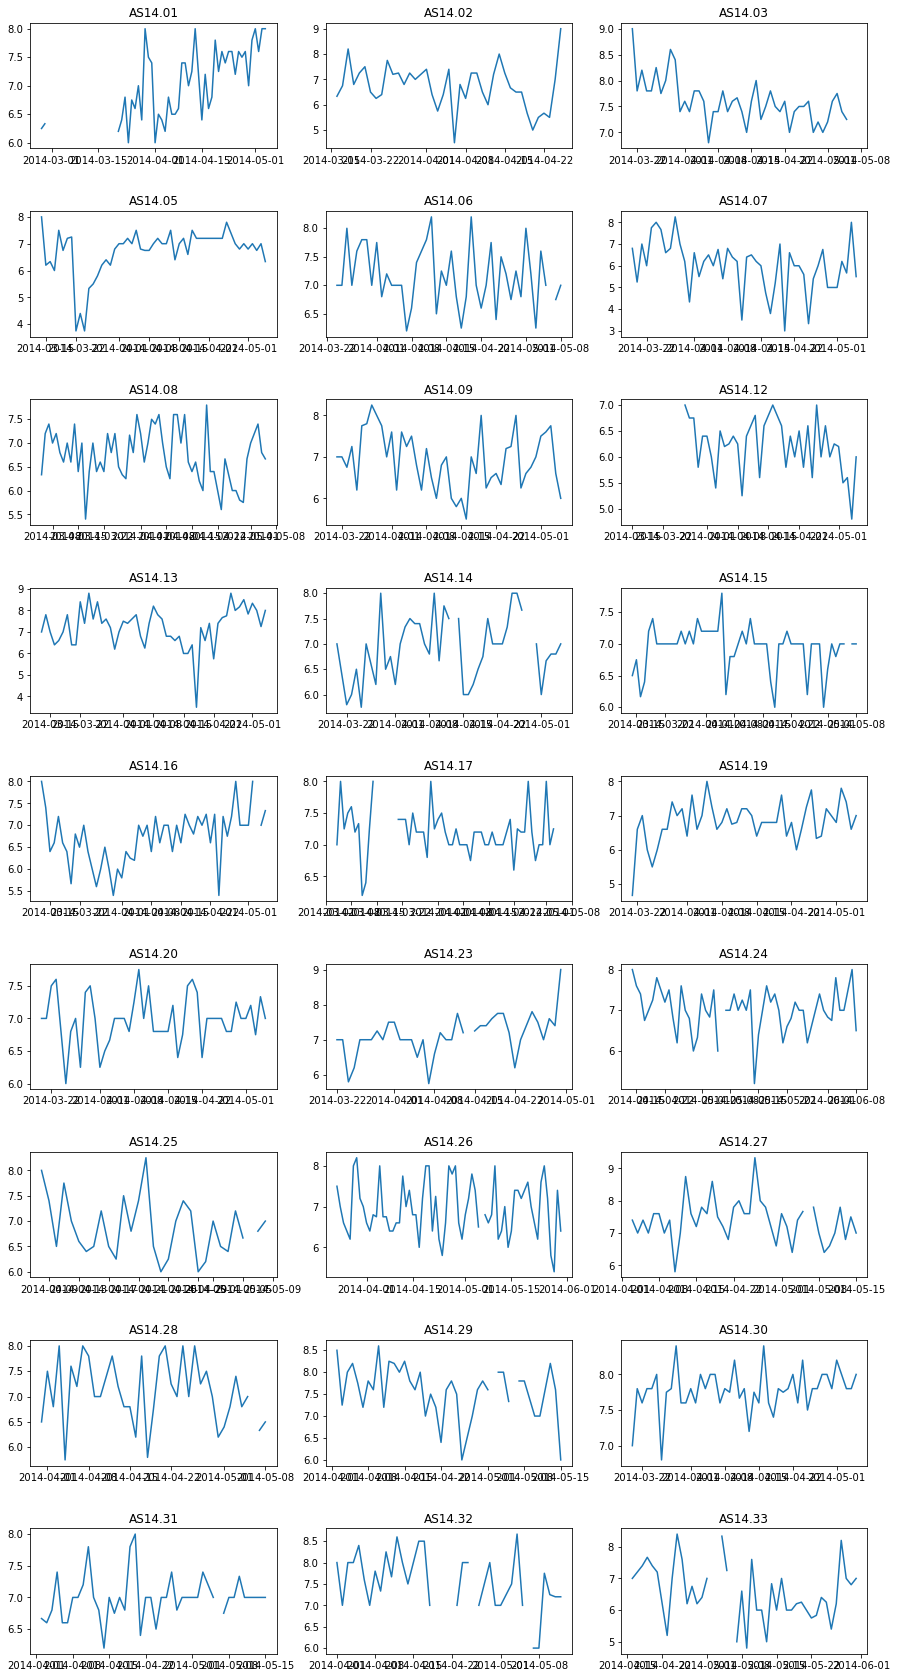

In [22]:
fig, axes = plt.subplots(nrows=int(np.ceil(len(df.id.unique()) / 3)), ncols=3)
fig.set_figheight(30)
fig.set_figwidth(15)
fig.subplots_adjust(hspace=0.5)

# Plot mood for each person
for ax, person in zip(axes.flatten(), df.id.unique()):
    mood = getPersonMoodArimaSet(person)
    ax.set(title=person)
    ax.plot(mood)

Not a lot, so this may not be relevant. We can probably just use ARIMA on the full set. For reference, the following persons have some big chunks of missing data:
- AS14.01 in the beginning
- AS14.17 in the beginning
- AS14.32 in the middle

Furthermore, some persons have small gaps in the end at the test set. Will look into this later.

For the sake of completeness, we will try all 2 sets on each person and see which dataset performs best.

In [24]:
df_results = pd.DataFrame(columns=df_pdq.columns[0:16], index=df.id.unique()) # init

# Do p,d,q experiment for each person, for each dataset
for person in df.id.unique():

    # Get mood set
    mood = getPersonMoodArimaSet(person)
    
    # Drop NaN mood set
    mood_dropna = mood.dropna()
    
    # Results for complete set
    pdq_results = do_experiment_ARIMA_find_pdq_values(mood, p_values, d_values, q_values, doPrint=False)
    pdq_results.sort_values('mse', inplace = True)
    pdq_results = pdq_results.reset_index()

    # Results for set with dropped NaN
    pdq_results_dropna = do_experiment_ARIMA_find_pdq_values(mood_dropna, p_values, d_values, q_values, doPrint=False)
    pdq_results_dropna.sort_values('mse', inplace = True)
    pdq_results_dropna = pdq_results_dropna.reset_index()
    
    # Get best results
    dfs_pdq = [pdq_results, pdq_results_dropna]
    df_pdq = pd.concat(dfs_pdq, axis=1, keys=range(1, len(dfs_pdq) + 1))
    df_pdq.columns = df_pdq.columns.map('{0[1]}{0[0]}'.format)

    # Save best orders and their mse 
    df_results.loc[person] = df_pdq.loc[0]

In [25]:
df_results.to_csv('results/arima.csv')

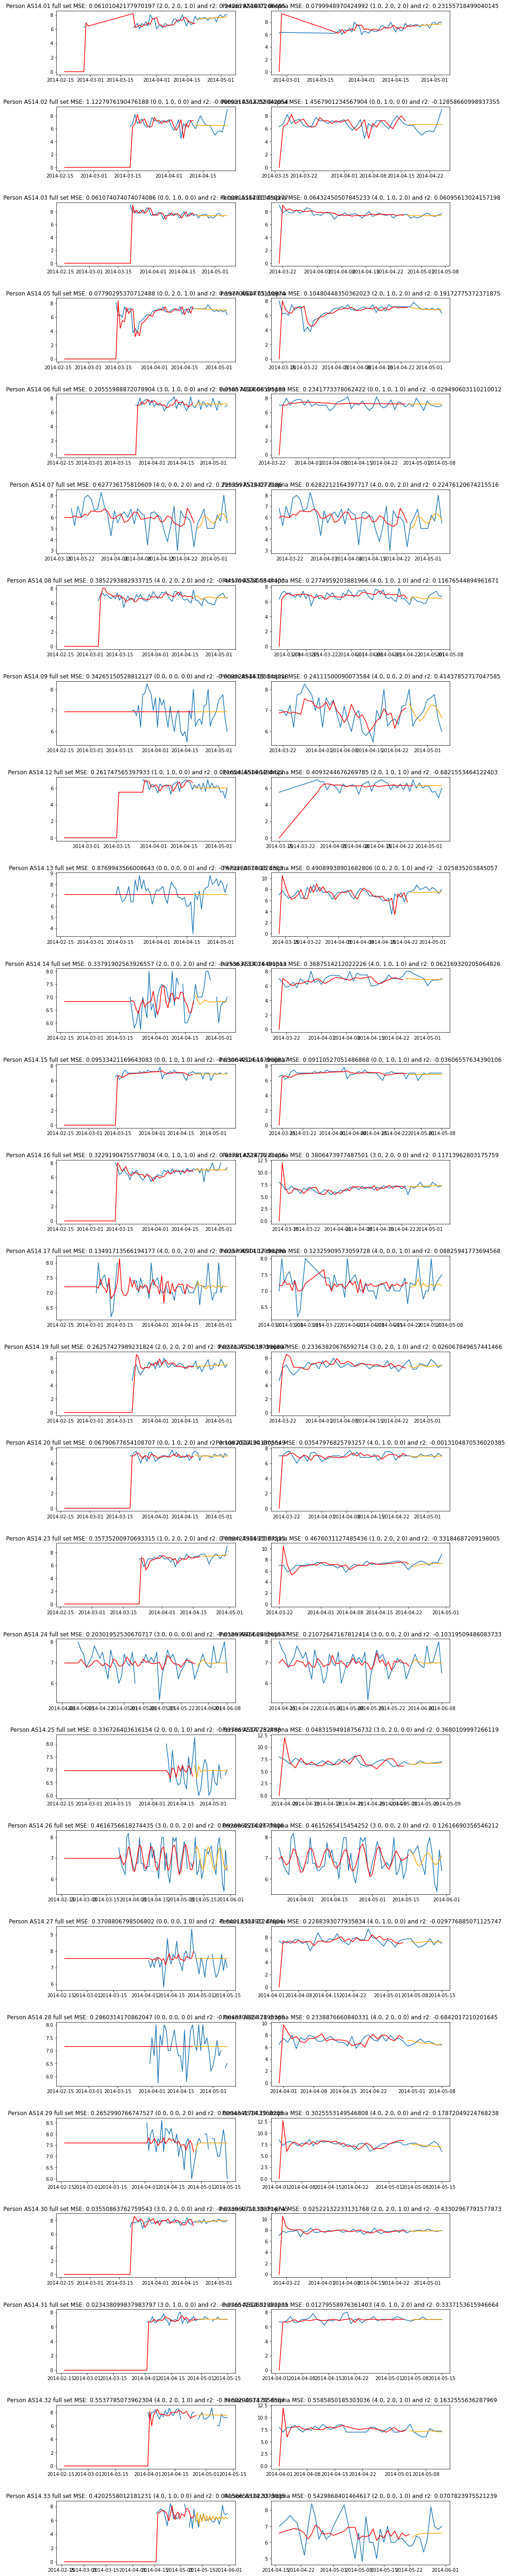

In [26]:
# Plotting stuff
fig, axes = plt.subplots(nrows=int(len(df.id.unique())), ncols=2)
fig.set_figheight(100)
fig.set_figwidth(15)
fig.subplots_adjust(hspace=0.5)
axs = axes.flatten()

# Plot arima fitted values and forecasting for each person
for i, person in enumerate(df.id.unique()):
    
    # Get mood set
    mood = getPersonMoodArimaSet(person)

    # Drop NaN mood set
    mood_dropna = mood.dropna()
    
    # Get training and test sets
    train, test = get_train_set_set(mood, perc_train)
    train_dropna, test_dropna = get_train_set_set(mood_dropna, perc_train)
    
    # Get arima orders
    pdq = (df_results.loc[person].p1, df_results.loc[person].d1, df_results.loc[person].q1)
    pdq_dropna = (df_results.loc[person].p2, df_results.loc[person].d2, df_results.loc[person].q2)
    
    # Train the models
    model_fit = model_fit_ARIMA(train, order=pdq)
    model_fit_dropna = model_fit_ARIMA(train_dropna, order=pdq_dropna)

    # Forecast and check accuracy
    forecast = model_fit.forecast(len(test))
    mse, r2 = evaluate(test, forecast)
    forecast_dropna = model_fit_dropna.forecast(len(test_dropna))
    mse_dropna, r2_dropna = evaluate(test_dropna, forecast_dropna)

    # Make axes
    ax = axs[i*2]
    ax_dropna = axs[i*2+1]
    
    # Plot full range
    ax.set_title(f'Person {person} full set MSE: {mse} {pdq} and r2: {r2}')
    ax.plot(mood)
    ax.plot(model_fit.fittedvalues, color='red')
    ax.plot(test.index, forecast, color='orange')
    
    # Plot dropped NaN
    ax_dropna.set_title(f'Person {person} dropna MSE: {mse_dropna} {pdq_dropna} and r2: {r2_dropna}')
    ax_dropna.plot(mood_dropna)
    ax_dropna.plot(model_fit_dropna.fittedvalues, color='red')
    ax_dropna.plot(test_dropna.index, forecast_dropna, color='orange')

Let's analyse which mood dataset performs better and what the training / test sets look like.

In [27]:
df_results['best'] = np.where(df_results['mse1'] < df_results['mse2'], 'full', 'nan')
df_results['diff'] =  np.where(df_results['mse1'] < df_results['mse2'], df_results['mse2'] - df_results['mse1'], df_results['mse1'] - df_results['mse2'])

print(f'Mean MSE of full range is \t{df_results["mse1"].mean()}')
print(f'Mean MSE of dropnan range is \t{df_results["mse2"].mean()}')

df_results

Mean MSE of full range is 	0.3169718609576978
Mean MSE of dropnan range is 	0.30789154208311365


p1 d1 q1       mse1          r21 tr_na1 tr1 tst1 p2 d2 q2       mse2  \
AS14.01  2  2  1  0.0610104     0.242629     32  62   15  1  2  2  0.0799949   
AS14.02  0  1  0     1.1228 -0.000921016     27  54   14  0  1  0    1.45679   
AS14.03  0  1  0  0.0610741  -0.00815162     32  64   15  4  1  2  0.0643245   
AS14.05  0  2  1   0.077903     0.197701     37  61   16  2  1  2   0.104804   
AS14.06  3  1  0    0.20556    0.0585745     29  64   16  0  1  1   0.234177   
AS14.07  4  0  2   0.627736      0.22536     38  40   10  4  0  2   0.628221   
AS14.08  4  2  2   0.385229    -0.441706     46  62   16  4  1  1   0.277496   
AS14.09  0  0  0   0.342652  -0.00952865     30  62   16  4  0  2   0.241115   
AS14.12  1  1  0   0.261748    0.0116542     25  60   16  2  1  1   0.409324   
AS14.13  0  0  0   0.876994     -0.67318     37  61   16  0  2  1   0.490899   
AS14.14  2  0  2   0.337919    -0.253631     30  62   14  4  1  1   0.368751   
AS14.15  0  1  1  0.0953342   -0.0306401     39  64   16  0  1  1  0.0911053   
AS14.16  4  1  1   0.322919    0.0378142     38  62   15  3  2  0   0.380647   
AS14.17  4  0  2   0.134917    0.0257909     41  62   15  4  0  1   0.123259   
AS14.19  2  2  2   0.262574    0.0271273     30  62   16  3  2  1   0.233638   
AS14.20  0  1  2  0.0679068     0.108201     31  62   16  4  1  0  0.0354798   
AS14.23  1  2  2   0.357352    0.0994279     27  61   12  1  2  2   0.467603   
AS14.24  3  0  0    0.20302   -0.0189995     43  49   12  3  0  2   0.210726   
AS14.25  2  0  1   0.336726   -0.0378692     14  64   16  3  2  0  0.0483159   
AS14.26  3  0  2   0.461676    0.0926962     47  82   21  3  0  2   0.461527   
AS14.27  0  0  1   0.370881    -0.640133     25  70   17  4  1  0   0.228839   
AS14.28  0  0  0   0.286031   -0.0648705     22  64   16  4  2  0   0.233888   
AS14.29  0  0  2   0.265299    0.0204342     26  70   16  4  2  0   0.302555   
AS14.30  3  2  0  0.0355086   -0.0239607     31  62   16  2  2  1  0.0252213   
AS14.31  3  1  0  0.0234381   -0.0265416     28  72   15  4  1  2  0.0127956   
AS14.32  4  2  1   0.553779    -0.316029     22  69   15  4  2  1   0.558585   
AS14.33  4  1  0   0.420256    0.0415666     22  83   21  2  0  1   0.542987   

                r22 tr_na2 tr2 tst2  best         diff  
AS14.01    0.231557     37  37   10  full    0.0189845  
AS14.02   -0.128587     32  32    9  full     0.333993  
AS14.03   0.0609561     37  37   10  full   0.00325043  
AS14.05    0.191728     42  42   11  full    0.0269015  
AS14.06  -0.0294906     36  36    9  full    0.0286174  
AS14.07    0.224761     38  38   10  full  0.000485041  
AS14.08    0.116765     49  49   13   nan     0.107733  
AS14.09    0.414379     36  36   10   nan     0.101537  
AS14.12   -0.682155     32  32    9  full     0.147577  
AS14.13    -2.02584     42  42   11   nan     0.386095  
AS14.14   0.0621693     35  35    9  full    0.0308324  
AS14.15  -0.0360656     44  44   11   nan   0.00422894  
AS14.16     0.11714     42  42   11  full    0.0577284  
AS14.17   0.0882594     44  44   12   nan     0.011658  
AS14.19   0.0260678     36  36   10   nan    0.0289361  
AS14.20 -0.00131049     37  37   10   nan     0.032427  
AS14.23   -0.331847     31  31    8  full     0.110251  
AS14.24   -0.103195     44  44   11  full   0.00770695  
AS14.25    0.368011     24  24    6   nan      0.28841  
AS14.26    0.126167     54  54   14   nan   0.00014912  
AS14.27  -0.0297769     33  33    9   nan     0.142041  
AS14.28   -0.684202     30  30    8   nan    0.0521438  
AS14.29     0.17872     33  33    9  full    0.0372562  
AS14.30    -0.43303     37  37   10   nan    0.0102873  
AS14.31    0.333715     34  34    9   nan    0.0106425  
AS14.32    0.163256     29  29    8  full   0.00480651  
AS14.33   0.0707824     34  34    9  full     0.122731

In [33]:
df_results_final = df_results.rename(columns = {'mse2': 'mse', 'r22': 'r2'})
df_results_final.loc[:,['mse', 'r2']].to_csv('results/arima_final.csv')

AS14.01
Test MSE: 0.0799948970424992 	for 1.0, 2.0 and 2.0
Test r2: 0.23155718499040145


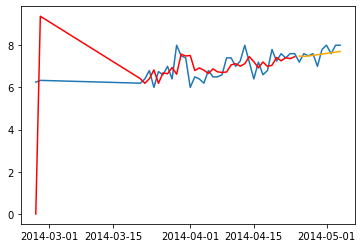

AS14.02
Test MSE: 1.4567901234567904 	for 0.0, 1.0 and 0.0
Test r2: -0.12858660998937355


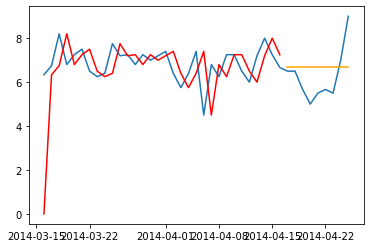

AS14.03
Test MSE: 0.06432450507845233 	for 4.0, 1.0 and 2.0
Test r2: 0.06095613024157198


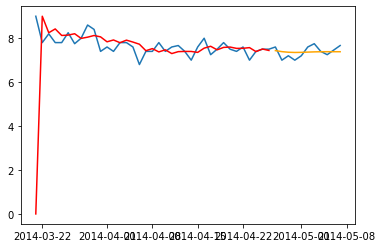

AS14.05
Test MSE: 0.10480448350362023 	for 2.0, 1.0 and 2.0
Test r2: 0.19172775372371875


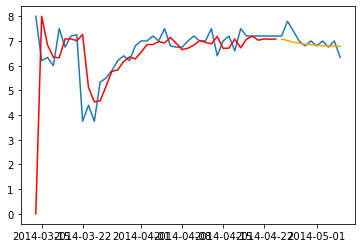

AS14.06
Test MSE: 0.2341773378062422 	for 0.0, 1.0 and 1.0
Test r2: -0.029490603110210012


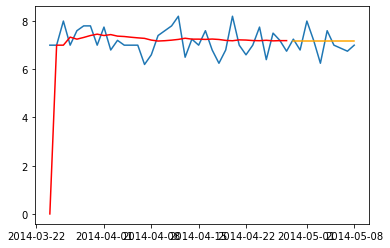

AS14.07
Test MSE: 0.6282212164397717 	for 4.0, 0.0 and 2.0
Test r2: 0.22476120674215516


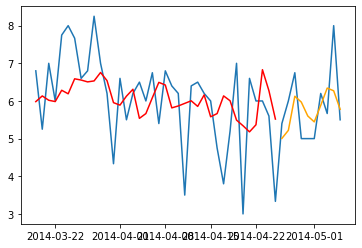

AS14.08
Test MSE: 0.2774959203881966 	for 4.0, 1.0 and 1.0
Test r2: 0.11676544894961671


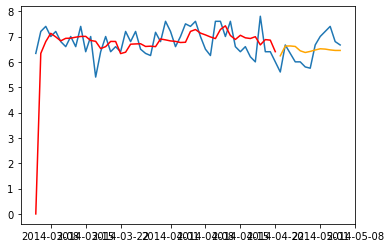

AS14.09
Test MSE: 0.24111500090073584 	for 4.0, 0.0 and 2.0
Test r2: 0.41437852717047585


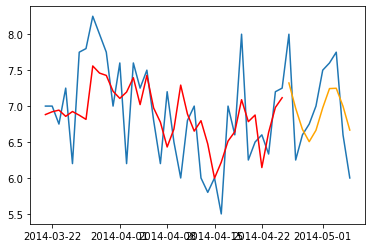

AS14.12
Test MSE: 0.4093244676269785 	for 2.0, 1.0 and 1.0
Test r2: -0.6821553464122403


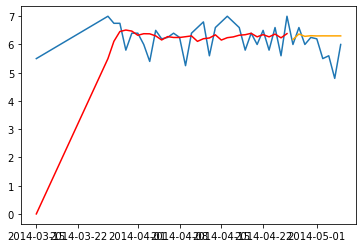

AS14.13
Test MSE: 0.49089938901682806 	for 0.0, 2.0 and 1.0
Test r2: -2.025835203845057


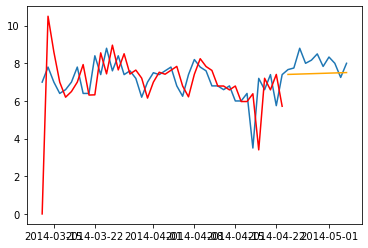

AS14.14
Test MSE: 0.3687514212022226 	for 4.0, 1.0 and 1.0
Test r2: 0.062169320205064826


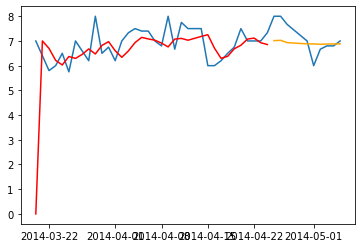

AS14.15
Test MSE: 0.09110527051486868 	for 0.0, 1.0 and 1.0
Test r2: -0.03606557634390106


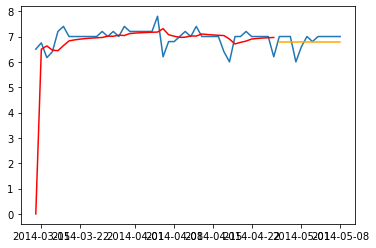

AS14.16
Test MSE: 0.3806473977487501 	for 3.0, 2.0 and 0.0
Test r2: 0.11713962803175759


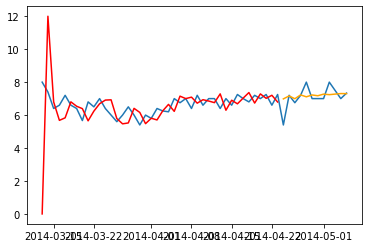

AS14.17
Test MSE: 0.12325909573059728 	for 4.0, 0.0 and 1.0
Test r2: 0.08825941773694568


AS14.19
Test MSE: 0.23363820676592714 	for 3.0, 2.0 and 1.0
Test r2: 0.026067849657441466


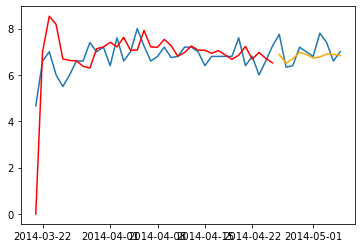

AS14.20
Test MSE: 0.03547976825793257 	for 4.0, 1.0 and 0.0
Test r2: -0.0013104870536020385


AS14.23
Test MSE: 0.4676031127485436 	for 1.0, 2.0 and 2.0
Test r2: -0.33184687209198005


AS14.24
Test MSE: 0.21072647167812414 	for 3.0, 0.0 and 2.0
Test r2: -0.10319509486083733


AS14.25
Test MSE: 0.04831594918756732 	for 3.0, 2.0 and 0.0
Test r2: 0.3680109997266119


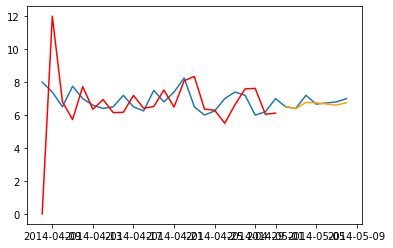

AS14.26
Test MSE: 0.4615265415454252 	for 3.0, 0.0 and 2.0
Test r2: 0.12616690356546212


AS14.27
Test MSE: 0.2288393077935834 	for 4.0, 1.0 and 0.0
Test r2: -0.029776885071125747


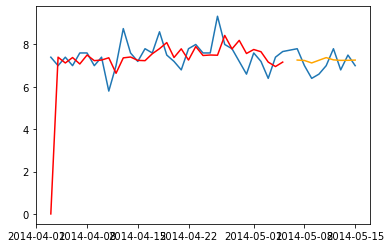

AS14.28
Test MSE: 0.2338876660840331 	for 4.0, 2.0 and 0.0
Test r2: -0.6842017210201645


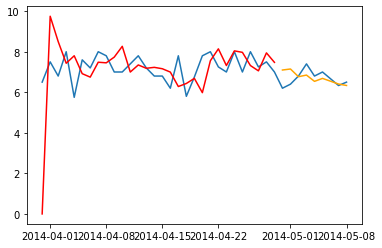

AS14.29
Test MSE: 0.3025553149546808 	for 4.0, 2.0 and 0.0
Test r2: 0.17872049224768238


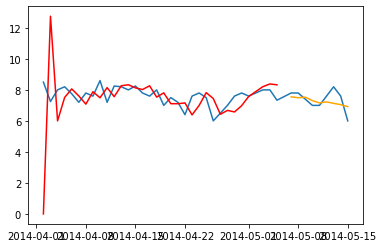

AS14.30
Test MSE: 0.02522132233131768 	for 2.0, 2.0 and 1.0
Test r2: -0.43302967791577873


AS14.31
Test MSE: 0.01279558976361403 	for 4.0, 1.0 and 2.0
Test r2: 0.3337153615946664


AS14.32
Test MSE: 0.5585850185303036 	for 4.0, 2.0 and 1.0
Test r2: 0.1632555636287969


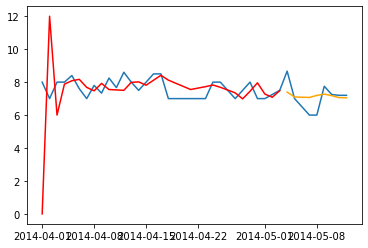

AS14.33
Test MSE: 0.5429868401464617 	for 2.0, 0.0 and 1.0
Test r2: 0.0707823975521239


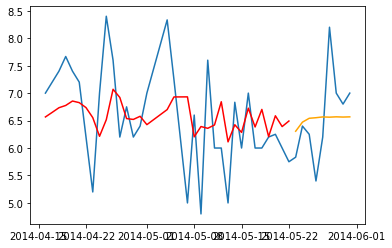

In [37]:
# Plot arima fitted values and forecasting for each person
for person in df.id.unique():
    print(person)
    # Get mood set
    mood = getPersonMoodArimaSet(person).dropna()

    # Get arima order
    pdq = (df_results.loc[person].p2, df_results.loc[person].d2, df_results.loc[person].q2)
    
    perform_ARIMA(mood, pdq)